In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import cv2
import numpy as np
import os
import pandas as pd
import random
import time

# For reproducible results
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    #torch.backends.cudnn.deterministic = True
    #torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

set_seed(0)


device = 'cuda' if torch.cuda.is_available() else 'cpu'
#device = 'cpu'

In [2]:
picture_files = sorted(os.listdir('Date Strings Part I/Part I/'))

In [3]:
picture_files2 = sorted(os.listdir('Date Strings Part II/Part II/'))

In [4]:
picture_files3 = sorted(os.listdir('Date Strings Part III/Part III/'))

In [5]:
pictures = {}
pictures2 = {}
pictures3 = {}

In [6]:
for picture_file in picture_files:
    im = cv2.imread('Date Strings Part I/Part I/' + picture_file)
    im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    im = cv2.resize(im, (128, 128))
    im = np.array(im, dtype=np.float32)
    im /= 255.0
    pictures[picture_file[:-4]] = im

In [7]:
for picture_file in picture_files2:
    im = cv2.imread('Date Strings Part II/Part II/' + picture_file)
    im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    im = cv2.resize(im, (128, 128))
    im = np.array(im, dtype=np.float32)
    im /= 255.0
    pictures2[picture_file[:-4]] = im

In [8]:
for picture_file in picture_files3:
    im = cv2.imread('Date Strings Part III/Part III/' + picture_file)
    im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    im = cv2.resize(im, (128, 128))
    im = np.array(im, dtype=np.float32)
    im /= 255.0
    pictures3[picture_file[:-4]] = im

In [9]:
pictures_train = []
labels_train = []
pictures_test = []
labels_test = []

In [10]:
dfs = pd.read_excel('Date Strings Part I/Part I.xlsx')
dfs2 = pd.read_excel('Date Strings Part II/Part II.xlsx')
dfs3 = pd.read_excel('Date Strings Part III/Part III.xlsx')
labels = {}
labels2 = {}
labels3 = {}

In [11]:
for i in range(2548):
    if not pd.isnull(dfs.iloc[i,:].Image_Left):
        labels[dfs.iloc[i,:].Image_Left] = [int(j) for j in str(dfs.iloc[i,:].Date)[1:]]
    if not pd.isnull(dfs.iloc[i,:].Image_Right):
        labels[dfs.iloc[i,:].Image_Right] = [int(j) for j in str(dfs.iloc[i,:].Date)[1:]]

In [12]:
for i in range(3296):
    if not pd.isnull(dfs2.iloc[i,:].Image_Left):
        labels2[dfs2.iloc[i,:].Image_Left] = [int(j) for j in str(dfs2.iloc[i,:].Date)[1:]]
    if not pd.isnull(dfs2.iloc[i,:].Image_Right):
        labels2[dfs2.iloc[i,:].Image_Right] = [int(j) for j in str(dfs2.iloc[i,:].Date)[1:]]

In [13]:
for i in range(1520):
    labels3[dfs3.iloc[i,:].Image_name] = [int(j) for j in str(dfs3.iloc[i,:].Date)[1:]]

In [14]:
for picture_file in picture_files:
    if (labels[picture_file[:-4]][0] == 9 and labels[picture_file[:-4]][1] < 2) or (labels[picture_file[:-4]][0] == 8):
        pictures_train.append(pictures[picture_file[:-4]])
        labels_train.append(labels[picture_file[:-4]])
    else:
        pictures_test.append(pictures[picture_file[:-4]])
        labels_test.append(labels[picture_file[:-4]])

In [15]:
for picture_file in picture_files2:
    pictures_train.append(pictures2[picture_file[:-4]])
    labels_train.append(labels2[picture_file[:-4]])

In [16]:
for picture_file in picture_files3:
    pictures_test.append(pictures3[picture_file[:-4]])
    labels_test.append(labels3[picture_file[:-4]])

In [17]:
len(pictures_train), len(labels_train), len(pictures_test), len(labels_test)

(7924, 7924, 2076, 2076)

In [18]:
pictures_train = np.array(pictures_train)
labels_train = np.array(labels_train, dtype=np.float32)
pictures_test = np.array(pictures_test)
labels_test = np.array(labels_test, dtype=np.float32)

In [19]:
train_x = torch.Tensor(pictures_train).type(torch.FloatTensor).to(device)
train_y = torch.Tensor(labels_train).type(torch.FloatTensor).to(device)
test_x = torch.Tensor(pictures_test).type(torch.FloatTensor).to(device)
test_y = torch.Tensor(labels_test).type(torch.FloatTensor).to(device)

train_dataset = torch.utils.data.TensorDataset(train_x, train_y)
test_dataset = torch.utils.data.TensorDataset(test_x, test_y)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=64)

In [20]:
class LSTMwith3Heads(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        
        super(LSTMwith3Heads, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
        
        self.second = nn.Sequential(
            nn.Dropout(p=0.2),
            nn.Linear(in_features=hidden_size, out_features=num_classes)
        )
        self.third = nn.Sequential(
            nn.Dropout(p=0.2),
            nn.Linear(in_features=hidden_size, out_features=num_classes)
        )
        self.fourth = nn.Sequential(
            nn.Dropout(p=0.2),
            nn.Linear(in_features=hidden_size, out_features=num_classes)
        )
    
    def forward(self, x):
        h = torch.zeros(self.num_layers, x.size(0), 
                        self.hidden_size).to(device) 
        c = torch.zeros(self.num_layers, x.size(0), 
                        self.hidden_size).to(device)
        
        out, _ = self.lstm(x, (h, c))  
                
        return {
            'second': self.second(out[:, -1, :]),   # Yüzler basamağı
            'third': self.third(out[:, -1, :]),     # Onlar basamağı
            'fourth': self.fourth(out[:, -1, :])    # Birler basamağı
        }

In [21]:
hidden_size = 128
num_classes = 10
input_size = 128
num_layers = 2

model = LSTMwith3Heads(input_size, hidden_size, num_layers, num_classes).to(device)

In [22]:
def criterion(loss_func, outputs, labelList):
  losses = 0
  losses += loss_func(outputs['second'], labelList[:, 0])
  losses += loss_func(outputs['third'], labelList[:, 1])
  losses += loss_func(outputs['fourth'], labelList[:, 2])
  return losses

In [23]:
def validate(model, train_loader, val_loader):
    model.eval()
    a1,b1,c1,d1,e1,a2,b2,c2,d2,e2 = 0,0,0,0,0,0,0,0,0,0
    
    for name, loader in [("train", train_loader), ("val", val_loader)]:
        correct = 0
        total = 0
        correct_digits = 0
        total_digits = 0
        correct_second_sum = 0
        correct_third_sum = 0
        correct_fourth_sum = 0
        

        with torch.no_grad():
            for imgs, labels in loader:
                outputs = model(imgs)
                predicted_second = torch.argmax(outputs['second'], dim=1)
                predicted_third = torch.argmax(outputs['third'], dim=1)
                predicted_fourth = torch.argmax(outputs['fourth'], dim=1)
                total += labels[:, 0].type(torch.LongTensor).to(device).shape[0]
                total_digits += labels[:, 0].type(torch.LongTensor).to(device).shape[0]*3
                correct_second = (predicted_second == labels[:, 0])
                correct_second_sum += int(correct_second.sum())
                correct_third = (predicted_third == labels[:, 1])
                correct_third_sum += int(correct_third.sum())
                correct_fourth = (predicted_fourth == labels[:, 2])
                correct_fourth_sum += int(correct_fourth.sum())
                correct_digits += int(correct_second.sum()) + int(correct_third.sum()) + int(correct_fourth.sum())
                correct_second_third = torch.logical_and(correct_second, correct_third)
                correct_second_third_fourth = torch.logical_and(correct_second_third, correct_fourth)
                correct += int(correct_second_third_fourth.sum())

        print("Başarim {}: {:.2f} : {:.2f}\nYüzler {}: {:.2f}\nOnlar {}: {:.2f}\nBirler {}: {:.2f}\n"
              .format(name , correct / total, correct_digits / total_digits, name, correct_second_sum / total,
                      name, correct_third_sum / total, name, correct_fourth_sum / total))
        if name == "train":
            a1,b1,c1,d1,e1 = correct / total, correct_digits / total_digits, correct_second_sum / total, correct_third_sum / total, correct_fourth_sum / total
        else:
            a2,b2,c2,d2,e2 = correct / total, correct_digits / total_digits, correct_second_sum / total, correct_third_sum / total, correct_fourth_sum / total
    
    return a1,b1,c1,d1,e1,a2,b2,c2,d2,e2
        
#validate(model, train_loader, test_loader)

In [24]:
a_1,b_1,c_1,d_1,e_1,a_2,b_2,c_2,d_2,e_2 = [], [], [], [], [], [], [], [], [], []

def training(model, lr_rate, epochs, train_loader):
  
  a2_max = 0
  optimizer = torch.optim.AdamW(model.parameters(), lr=lr_rate) # decouples weight decay from the gradient update

  loss_func = nn.CrossEntropyLoss()
  
  #scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=20, verbose=True, factor=0.25)
  
  for epoch in range(1, epochs+1):
    model.train()
    loss_per_epoch = 0
    for pictures in train_loader:

     outputs = model(pictures[0])

     loss = criterion(loss_func, outputs, pictures[1].type(torch.LongTensor).to(device))

     optimizer.zero_grad()
     loss.backward()
     optimizer.step()
     loss_per_epoch += loss.detach().cpu().numpy()
    
      
    #scheduler.step(checkpoint_loss)
    if epoch % 5 == 0 or epoch == 1:
      print (f'Epoch [{epoch}/{epochs}], Loss: {loss_per_epoch/64:.4f}')
      a1,b1,c1,d1,e1,a2,b2,c2,d2,e2 = validate(model, train_loader, test_loader)
      a_1.append(a1)
      b_1.append(b1)
      c_1.append(c1)
      d_1.append(d1)
      e_1.append(e1)
      a_2.append(a2)
      b_2.append(b2)
      c_2.append(c2)
      d_2.append(d2)
      e_2.append(e2)
    
    if a2 > a2_max:
      a2_max = a2
      torch.save(model.state_dict(), 'model.pt')
    
    #if a2 <= sum(a_2[-10:])/10:
    #scheduler.step(a2)
    
    if a2 < sum(a_2[-15:])/15:
      break
    
  return

model = LSTMwith3Heads(input_size, hidden_size, num_layers, num_classes).to(device)
time_start = time.time()
training(model, 1e-3, 1000, train_loader)
time_end = time.time()
elapse_time = time_end - time_start
print('Finished in {}s'.format(int(elapse_time)))
#torch.save(model.state_dict(), '1e-3,300_epochs.pt')

Epoch [1/1000], Loss: 7.9222
Başarim train: 0.04 : 0.45
Yüzler train: 0.79
Onlar train: 0.46
Birler train: 0.11

Başarim val: 0.03 : 0.43
Yüzler val: 0.85
Onlar val: 0.34
Birler val: 0.09

Epoch [5/1000], Loss: 7.5325
Başarim train: 0.04 : 0.45
Yüzler train: 0.79
Onlar train: 0.46
Birler train: 0.11

Başarim val: 0.03 : 0.43
Yüzler val: 0.85
Onlar val: 0.34
Birler val: 0.10

Epoch [10/1000], Loss: 7.5046
Başarim train: 0.04 : 0.45
Yüzler train: 0.79
Onlar train: 0.45
Birler train: 0.11

Başarim val: 0.03 : 0.42
Yüzler val: 0.84
Onlar val: 0.33
Birler val: 0.10

Epoch [15/1000], Loss: 7.4726
Başarim train: 0.04 : 0.43
Yüzler train: 0.75
Onlar train: 0.43
Birler train: 0.10

Başarim val: 0.03 : 0.40
Yüzler val: 0.78
Onlar val: 0.33
Birler val: 0.10

Epoch [20/1000], Loss: 7.4693
Başarim train: 0.04 : 0.43
Yüzler train: 0.75
Onlar train: 0.44
Birler train: 0.11

Başarim val: 0.03 : 0.40
Yüzler val: 0.78
Onlar val: 0.33
Birler val: 0.10

Epoch [25/1000], Loss: 7.4716
Başarim train: 0.04 : 

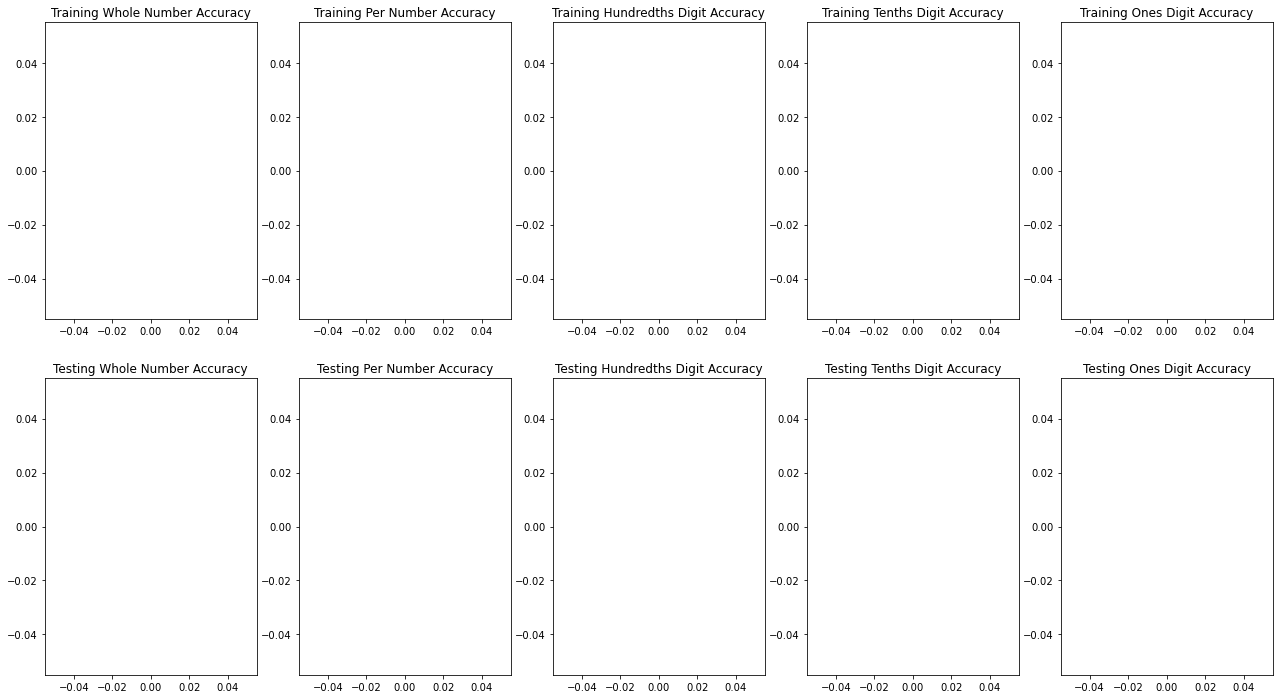

In [39]:
xpoints = list(range(1, 5*(len(a_1)), 5))

f, axarr = plt.subplots(2,5, figsize=(22,12))
axarr[0,0].title.set_text("Training Whole Number Accuracy")
axarr[0,0].plot(xpoints, a_1, color='blue')
axarr[0,1].title.set_text("Training Per Number Accuracy")
axarr[0,1].plot(xpoints, b_1, color='blue')
axarr[0,2].title.set_text("Training Hundredths Digit Accuracy")
axarr[0,2].plot(xpoints, c_1, color='blue')
axarr[0,3].title.set_text("Training Tenths Digit Accuracy")
axarr[0,3].plot(xpoints, d_1, color='blue')
axarr[0,4].title.set_text("Training Ones Digit Accuracy")
axarr[0,4].plot(xpoints, e_1, color='blue')
axarr[1,0].title.set_text("Testing Whole Number Accuracy")
axarr[1,0].plot(xpoints, a_2, color='blue')
axarr[1,1].title.set_text("Testing Per Number Accuracy")
axarr[1,1].plot(xpoints, b_2, color='blue')
axarr[1,2].title.set_text("Testing Hundredths Digit Accuracy")
axarr[1,2].plot(xpoints, c_2, color='blue')
axarr[1,3].title.set_text("Testing Tenths Digit Accuracy")
axarr[1,3].plot(xpoints, d_2, color='blue')
axarr[1,4].title.set_text("Testing Ones Digit Accuracy")
axarr[1,4].plot(xpoints, e_2, color='blue')

  0%|          | 0/100 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 2.31E-03


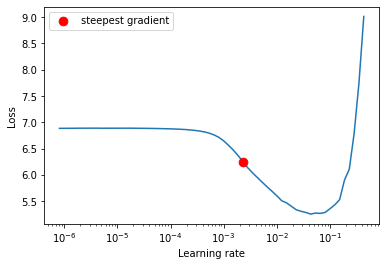

In [ ]:
# Buradan beklediğim gibi sonuç alamadım.

from torch_lr_finder import LRFinder

model = LSTMwith3Heads(input_size, hidden_size, num_layers, num_classes).to(device)
def criterion(outputs, labelList):
  loss_func = nn.CrossEntropyLoss()
  losses = 0
  losses += loss_func(outputs['second'], labelList[:, 0].type(torch.LongTensor).to(device))
  losses += loss_func(outputs['third'], labelList[:, 1].type(torch.LongTensor).to(device))
  losses += loss_func(outputs['fourth'], labelList[:, 2].type(torch.LongTensor).to(device))
  return losses
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-7, weight_decay=1e-2)
lr_finder = LRFinder(model, optimizer, criterion, device="cuda")
lr_finder.range_test(train_loader, end_lr=100, num_iter=100)
lr_finder.plot() # to inspect the loss-learning rate graph
lr_finder.reset() # to reset the model and optimizer to their initial state

In [42]:
def training(model, lr_rate, epochs, train_loader):
  
  optimizer = torch.optim.AdamW(model.parameters(), lr=lr_rate) # decouples weight decay from the gradient update

  def criterion(outputs, labelList):
    loss_func = nn.CrossEntropyLoss()
    losses = 0
    losses += loss_func(outputs['second'], labelList[:, 0].type(torch.LongTensor).to(device))
    losses += loss_func(outputs['third'], labelList[:, 1].type(torch.LongTensor).to(device))
    losses += loss_func(outputs['fourth'], labelList[:, 2].type(torch.LongTensor).to(device))
    return losses
  
  #scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', threshold=0.01, patience=5, verbose=True, factor=0.5)
  scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=lr_rate, steps_per_epoch=len(train_loader), epochs=epochs)
  for epoch in range(1, epochs+1):
    model.train()
    loss_per_epoch = 0
    for pictures in train_loader:

     outputs = model(pictures[0])

     loss = criterion(outputs, pictures[1].type(torch.LongTensor).to(device))

     optimizer.zero_grad()
     loss.backward()
     optimizer.step()
     scheduler.step()
     
     loss_per_epoch += loss.detach().cpu().numpy()
    
      
    #scheduler.step(checkpoint_loss)
    if epoch % 20 == 0 or epoch == 1:
      print (f'Epoch [{epoch}/{epochs}], Loss: {loss_per_epoch/64:.4f}')
      validate(model, train_loader, test_loader)
      
  return

model = LSTMwith3Heads(input_size, hidden_size, num_layers, num_classes).to(device)
time_start = time.time()
training(model, 2.31E-03, 200, train_loader)
time_end = time.time()
elapse_time = time_end - time_start
print('Finished in {}s'.format(int(elapse_time)))

Epoch [1/200], Loss: 10.0866
Başarım train: 0.04 : 0.45
Yüzler train: 0.79
Onlar train: 0.46
Birler train: 0.11

Başarım val: 0.03 : 0.43
Yüzler val: 0.85
Onlar val: 0.34
Birler val: 0.11

Epoch [20/200], Loss: 7.5164
Başarım train: 0.04 : 0.45
Yüzler train: 0.79
Onlar train: 0.46
Birler train: 0.11

Başarım val: 0.03 : 0.43
Yüzler val: 0.85
Onlar val: 0.34
Birler val: 0.10

Epoch [40/200], Loss: 7.4843
Başarım train: 0.04 : 0.46
Yüzler train: 0.79
Onlar train: 0.47
Birler train: 0.11

Başarım val: 0.03 : 0.43
Yüzler val: 0.85
Onlar val: 0.34
Birler val: 0.11

Epoch [60/200], Loss: 7.4834
Başarım train: 0.04 : 0.46
Yüzler train: 0.79
Onlar train: 0.47
Birler train: 0.11

Başarım val: 0.04 : 0.43
Yüzler val: 0.85
Onlar val: 0.34
Birler val: 0.11

Epoch [80/200], Loss: 7.4578
Başarım train: 0.05 : 0.46
Yüzler train: 0.79
Onlar train: 0.47
Birler train: 0.12

Başarım val: 0.03 : 0.43
Yüzler val: 0.85
Onlar val: 0.34
Birler val: 0.11

Epoch [100/200], Loss: 7.4257
Başarım train: 0.05 : 0.4

In [ ]:
# Baseline'ları ise en çok bulunan rakamı baz alarak oluşturuyorum dummy classifier olarak.

In [43]:
yüzler = 10*[0]
onlar = 10*[0]
birler = 10*[0]

for data, label in train_loader:
    for i in label:
        yüzler[int(i[0].cpu().detach())] += 1
        onlar[int(i[1].cpu().detach())] += 1
        birler[int(i[2].cpu().detach())] += 1

yüzler, onlar, birler

([0, 0, 0, 0, 0, 0, 0, 0, 1680, 6244],
 [3661, 2583, 0, 0, 0, 0, 0, 0, 0, 1680],
 [687, 746, 738, 722, 712, 885, 876, 879, 843, 836])

<BarContainer object of 10 artists>

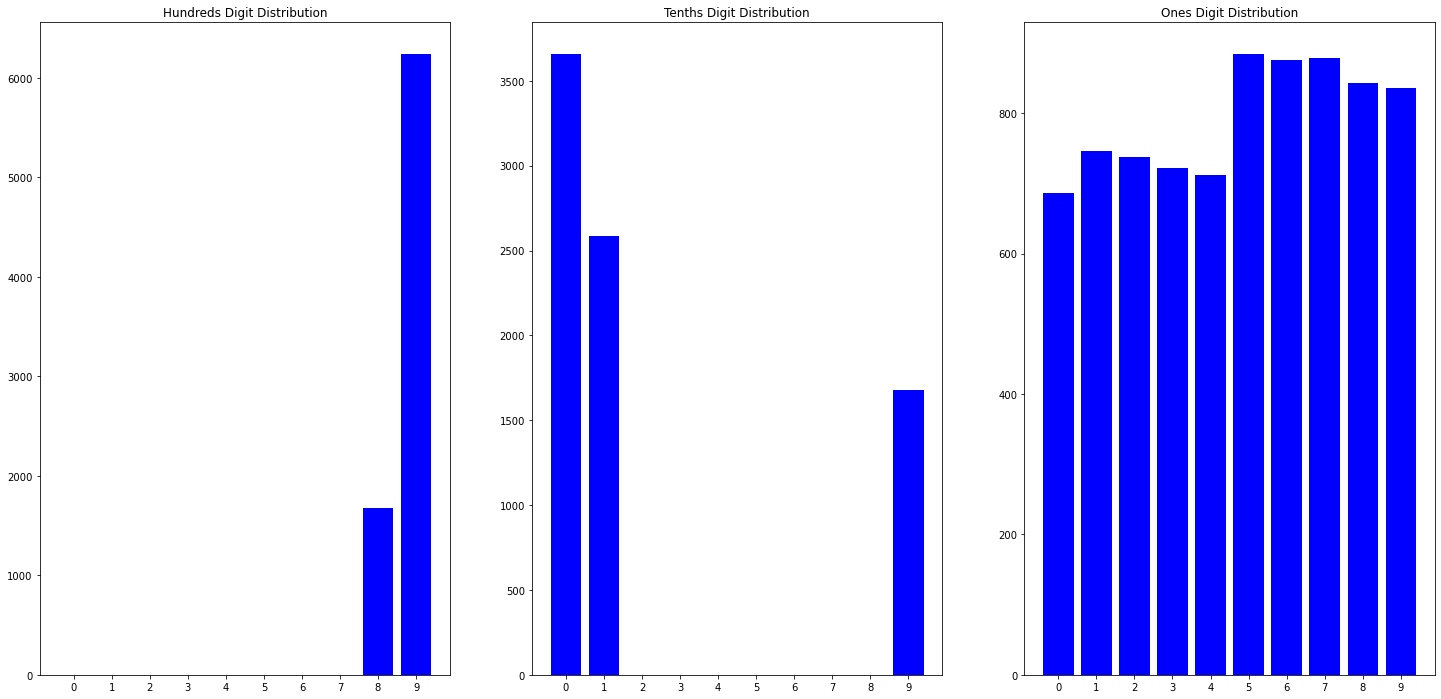

In [53]:
f, axarr = plt.subplots(1,3, figsize=(25,12))
axarr[0].title.set_text("Hundreds Digit Distribution")
axarr[0].bar(range(10), yüzler, color='blue', tick_label=range(10))
axarr[1].title.set_text("Tenths Digit Distribution")
axarr[1].bar(range(10), onlar, color='blue', tick_label=range(10))
axarr[2].title.set_text("Ones Digit Distribution")
axarr[2].bar(range(10), birler, color='blue', tick_label=range(10))

In [54]:
yüzler_test = 10*[0]
onlar_test = 10*[0]
birler_test = 10*[0]

for data, label in test_loader:
    for i in label:
        yüzler_test[int(i[0].cpu().detach())] += 1
        onlar_test[int(i[1].cpu().detach())] += 1
        birler_test[int(i[2].cpu().detach())] += 1

yüzler_test, onlar_test, birler_test

([0, 0, 0, 0, 0, 0, 0, 0, 308, 1768],
 [702, 347, 446, 150, 60, 40, 14, 9, 0, 308],
 [237, 218, 203, 180, 185, 222, 219, 212, 208, 192])

<BarContainer object of 10 artists>

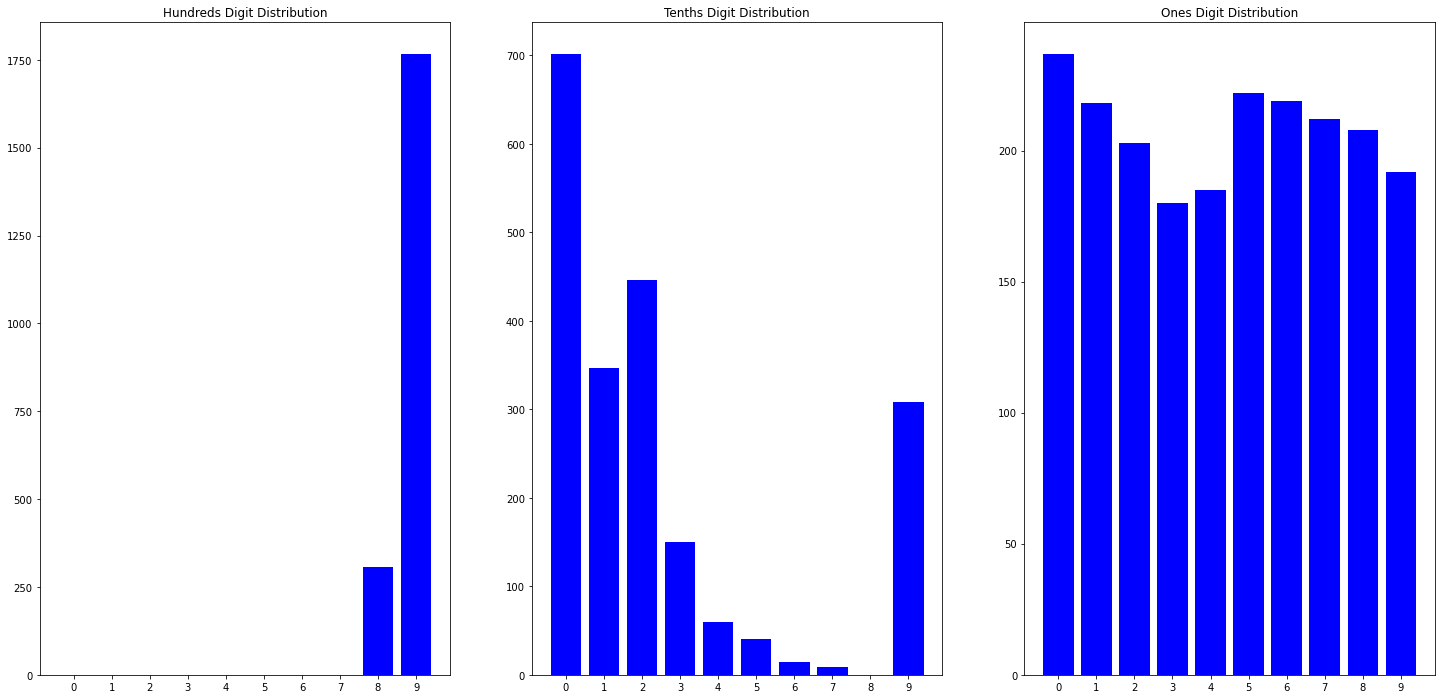

In [56]:
f, axarr = plt.subplots(1,3, figsize=(25,12))
axarr[0].title.set_text("Hundreds Digit Distribution")
axarr[0].bar(range(10), yüzler_test, color='blue', tick_label=range(10))
axarr[1].title.set_text("Tenths Digit Distribution")
axarr[1].bar(range(10), onlar_test, color='blue', tick_label=range(10))
axarr[2].title.set_text("Ones Digit Distribution")
axarr[2].bar(range(10), birler_test, color='blue', tick_label=range(10))

In [ ]:
"""
Epoch [210/1000], Loss: 1.0556
Başarim train: 0.84 : 0.94
Yüzler train: 0.99
Onlar train: 0.93
Birler train: 0.91

Başarim val: 0.22 : 0.58 # Binler basamaği dahil değil, hep 1'ler zaten.
Yüzler val: 0.86
Onlar val: 0.38
Birler val: 0.50

Finished in 579s
"""

In [57]:
yüzler_test[9] / (yüzler_test[9] + yüzler_test[8])
# %86 elde edilmişti; baseline %85 => Başarı

0.8516377649325626

In [58]:
onlar_test[0] / sum(onlar_test)
# %38 elde edilmişti; baseline %33 => Başarı

0.33815028901734107

In [59]:
birler_test[5] / sum(birler_test)
# %50 elde edilmişti; baseline %10 => Başarı

0.1069364161849711

In [30]:
#torch.save(model.state_dict(), 'lstm3heads.pth')

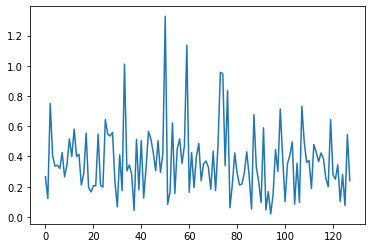

In [96]:
plt.plot(range(128), np.std(list(model.second.parameters())[0].data.numpy(), axis=0))

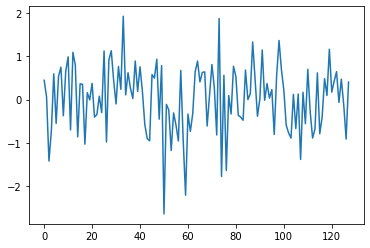

In [97]:
plt.plot(range(128), np.mean(list(model.second.parameters())[0].data.numpy(), axis=0))

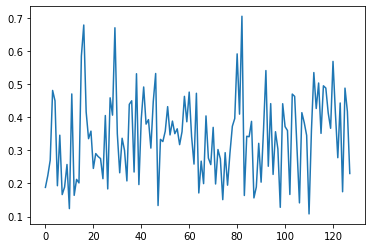

In [98]:
plt.plot(range(128), np.std(list(model.fourth.parameters())[0].data.numpy(), axis=0))

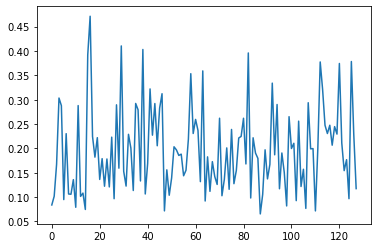

In [103]:
plt.plot(range(128), np.std(np.abs(list(model.fourth.parameters())[0].data.numpy()), axis=0))

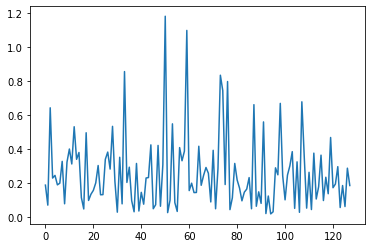

In [104]:
plt.plot(range(128), np.std(np.abs(list(model.second.parameters())[0].data.numpy()), axis=0))

In [79]:
hidden_size = 128
num_classes = 10
input_size = 128
num_layers = 2

model = LSTMwith3Heads(input_size, hidden_size, num_layers, num_classes).to(device)

model.load_state_dict(torch.load('model.pt', map_location=device))

<All keys matched successfully>

In [22]:
preds_second = []
preds_third = []
preds_fourth = []
labels_second = []
labels_third = []
labels_fourth = []

for data, label in test_loader:
    outputs = model(data)
    predicted_second = torch.argmax(outputs['second'], dim=1)
    predicted_third = torch.argmax(outputs['third'], dim=1)
    predicted_fourth = torch.argmax(outputs['fourth'], dim=1)
    preds_second.append(predicted_second.cpu().detach().numpy())
    preds_third.append(predicted_third.cpu().detach().numpy())
    preds_fourth.append(predicted_fourth.cpu().detach().numpy())
    labels_second.append(label[:, 0].cpu().detach().numpy())
    labels_third.append(label[:, 1].cpu().detach().numpy())
    labels_fourth.append(label[:, 2].cpu().detach().numpy())

In [23]:
from sklearn.metrics import classification_report, confusion_matrix

target_names = [8,9]
y_pred = (model(test_x)['second']).argmax(dim=1).cpu().detach().numpy()
print(classification_report(test_y[:,0].cpu().detach().numpy(), y_pred, labels=target_names))
# Recall: Gerçek değerler arasında doğru bildikleri
# Precision: Tahmin edilenler arasında doğru bildikleri

              precision    recall  f1-score   support

           8       0.55      0.46      0.50       308
           9       0.91      0.93      0.92      1768

    accuracy                           0.86      2076
   macro avg       0.73      0.70      0.71      2076
weighted avg       0.86      0.86      0.86      2076



In [24]:
confusion_matrix(test_y[:,0].cpu().detach().numpy(), y_pred, labels=[8,9])

array([[ 143,  165],
       [ 117, 1651]])

In [80]:
# Görüldüğü üzere gerçekte 8 olanları 9 olarak tahminlemesi daha fazla.

In [26]:
target_names = [0,1,2,3,4,5,6,7,8,9]
y_pred = (model(test_x)['third']).argmax(dim=1).cpu().detach().numpy()
print(classification_report(test_y[:,1].cpu().detach().numpy(), y_pred, labels=target_names))

              precision    recall  f1-score   support

           0       0.45      0.70      0.55       702
           1       0.24      0.50      0.33       347
           2       0.00      0.00      0.00       446
           3       0.00      0.00      0.00       150
           4       0.00      0.00      0.00        60
           5       0.00      0.00      0.00        40
           6       0.00      0.00      0.00        14
           7       0.00      0.00      0.00         9
           8       0.00      0.00      0.00         0
           9       0.55      0.49      0.52       308

   micro avg       0.39      0.39      0.39      2076
   macro avg       0.12      0.17      0.14      2076
weighted avg       0.28      0.39      0.32      2076



/home/cosmos/anaconda3/envs/th11/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/cosmos/anaconda3/envs/th11/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/cosmos/anaconda3/envs/th11/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/cos

In [27]:
confusion_matrix(test_y[:,1].cpu().detach().numpy(), y_pred, labels=[0,1,2,3,4,5,6,7,8,9])

array([[491, 159,   0,   0,   0,   0,   0,   0,   0,  52],
       [146, 175,   0,   0,   0,   0,   0,   0,   0,  26],
       [238, 187,   0,   0,   0,   0,   0,   0,   0,  21],
       [ 67,  72,   0,   0,   0,   0,   0,   0,   0,  11],
       [ 30,  26,   0,   0,   0,   0,   0,   0,   0,   4],
       [ 17,  17,   0,   0,   0,   0,   0,   0,   0,   6],
       [ 12,   1,   0,   0,   0,   0,   0,   0,   0,   1],
       [  1,   6,   0,   0,   0,   0,   0,   0,   0,   2],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [ 82,  74,   0,   0,   0,   0,   0,   0,   0, 152]])

In [83]:
# Görüldüğü üzere gerçekte 2 olup da 0 ve 1 olarak tahminledikleri, gerçekte 1 olup da 0 olarak tahminledikleri,
# gerçekte 0 olup da 1 olarak tahminledikleri ağırlıkta görünüyor. 1'in üstündekiler (9 hariç) hep yanlış, eğitim setinde olmadıkları için.

In [28]:
target_names = [0,1,2,3,4,5,6,7,8,9]
y_pred = (model(test_x)['fourth']).argmax(dim=1).cpu().detach().numpy()
print(classification_report(test_y[:,2].cpu().detach().numpy(), y_pred, labels=target_names))

              precision    recall  f1-score   support

           0       0.57      0.27      0.37       237
           1       0.50      0.29      0.37       218
           2       0.43      0.54      0.48       203
           3       0.34      0.41      0.37       180
           4       0.69      0.62      0.66       185
           5       0.65      0.63      0.64       222
           6       0.52      0.65      0.57       219
           7       0.69      0.53      0.60       212
           8       0.33      0.52      0.40       208
           9       0.58      0.65      0.61       192

    accuracy                           0.51      2076
   macro avg       0.53      0.51      0.51      2076
weighted avg       0.53      0.51      0.50      2076



In [29]:
confusion_matrix(test_y[:,2].cpu().detach().numpy(), y_pred, labels=[0,1,2,3,4,5,6,7,8,9])

array([[ 64,  35,  28,  15,   7,   4,  26,   8,  42,   8],
       [ 21,  63,  29,  20,   7,   2,   8,   4,  55,   9],
       [  4,   2, 110,  44,   0,   8,  13,   2,  17,   3],
       [  1,   0,  36,  73,   3,  19,  12,   9,  23,   4],
       [  5,   4,   9,   1, 115,   4,  16,   4,  14,  13],
       [  0,   3,   4,  21,   5, 140,  17,   9,  20,   3],
       [  7,   3,  21,  10,   2,  13, 142,   0,  18,   3],
       [  1,   2,   7,  12,   7,  16,  12, 112,  15,  28],
       [  7,  14,   7,  15,   7,   5,  25,   3, 108,  17],
       [  3,   1,   7,   3,  13,   6,   4,  11,  20, 124]])

In [ ]:
# Görüldüğü üzere gerçekte 3 olup da 2, 8 olarak tahminledikleri, gerçekte 2 olup da 3 olarak tahminledikleri,
# gerçekte 0 olup da 1 olarak tahminledikleri, gerçekte 1 olup da 8 olarak tahminledikleri (burası biraz beklenmedik gibi duruyor),
# gerçekte 8 olup da 3,6,9 olarak tahminledikleri ağırlıkta görünüyor.

In [34]:
iter = iter(test_loader)

In [35]:
sample = next(iter)

In [37]:
sample[0].shape

torch.Size([64, 128, 128])

In [40]:
im.shape

(128, 128)

In [26]:
output = model(sample[0])

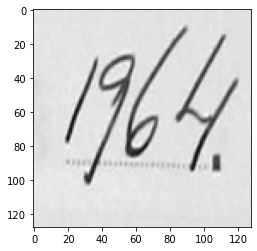

In [37]:
number = -4
plt.imshow(sample[0][number].cpu().detach().numpy(), cmap='gray')

In [28]:
picture_file = 'v120988.b1170.jpg'
im = cv2.imread('Date Strings Part III/Part III/' + picture_file)
im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
im = cv2.resize(im, (128, 128))
im = np.array(im, dtype=np.float32)
im /= 255.0
im = im.reshape(1, 128, 128)
im = torch.from_numpy(im)

output = model(im)
print(1, int(torch.argmax(output['second'])), int(torch.argmax(output['third'])), int(torch.argmax(output['fourth'])))

1 9 0 4


In [29]:
output['second'], output['third'], output['fourth']

(tensor([[-21.4118, -21.2952, -21.6520, -22.0227, -21.7362, -21.5830, -20.7455,
          -21.6856,  -3.2640,   5.0453]], grad_fn=<AddmmBackward0>),
 tensor([[  4.4948,   0.0818, -19.2616, -20.4326, -20.2741, -19.5471, -19.8614,
          -19.9373, -20.3733,  -6.0247]], grad_fn=<AddmmBackward0>),
 tensor([[ 6.0402e-03, -1.7986e+00, -4.1739e+00, -3.1109e+00,  7.4938e+00,
          -1.0676e+00, -1.9077e+00, -4.0978e+00,  2.2551e+00, -1.4258e+00]],
        grad_fn=<AddmmBackward0>))

In [ ]:
# Veri artırım yöntemleriyle başarım artırılabilir.